# Mohammad Amin Kiani - 4043644008
## N Queen problem
##### T3.HW1 - EA - Dr.Karshenas
##### ui.ac.ir

## Imports & Load...

In [27]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

## EA Funcs

In [28]:
def nqueens_conflicts(perm):
    """
    perm: آرایه/لیست جایگشتی طول n
         perm[col] = row ملکه در آن ستون
    چون نمایش جایگشتی است، هیچ دو ملکه‌ای روی یک سطر نیستند
    فقط باید برخورد قطرها را بشماریم.
    خروجی: تعداد زوج‌های ملکه که همدیگر را تهدید می‌کنند.
    """
    n = len(perm)
    conflicts = 0
    for i in range(n):
        for j in range(i+1, n):
            # روی قطر اصلی یا قطر فرعی؟
            if abs(perm[i] - perm[j]) == abs(i - j):
                conflicts += 1
    return conflicts

def nqueens_fitness(perm):
    """
    تابع برازندگی: هر چه تعداد برخوردها کمتر، برازندگی بیشتر.
    اینجا از فرم ساده استفاده می‌کنیم:
        fitness = 1 / (1 + conflicts)
    بنابراین جواب بدون برخورد (conflicts=0) برازندگی 1 دارد.
    """
    c = nqueens_conflicts(perm)
    return 1.0 / (1.0 + c)

def evaluate_population_nqueens(pop):
    return np.array([nqueens_fitness(ind) for ind in pop], dtype=float)

## Selection

In [29]:
def roulette_wheel_selection(pop, fitnesses, num_selected):
    """
    انتخاب متناسب با برازندگی (چرخ‌گردونه).
    اگر مجموع برازندگی صفر بود → انتخاب یکنواخت تصادفی.
    """
    pop_size = len(pop)
    total_fit = float(np.sum(fitnesses))
    if total_fit <= 0:
        idx = np.random.randint(0, pop_size, size=num_selected)
        return pop[idx].copy()

    probs = fitnesses / total_fit
    cum_probs = np.cumsum(probs)
    selected = []
    for _ in range(num_selected):
        r = np.random.rand()
        idx = np.searchsorted(cum_probs, r)
        selected.append(pop[idx].copy())
    return np.array(selected)

def tournament_selection(pop, fitnesses, num_selected, tournament_size=2):
    """
    رقابت دودویی با جایگزینی (برای بخش اختیاری خ).
    """
    pop_size = len(pop)
    selected = []
    for _ in range(num_selected):
        competitors = np.random.choice(pop_size, size=tournament_size, replace=False)
        best_idx = competitors[0]
        for idx in competitors[1:]:
            if fitnesses[idx] > fitnesses[best_idx]:
                best_idx = idx
        selected.append(pop[best_idx].copy())
    return np.array(selected)

## CrossOver

In [30]:
def cycle_crossover(p1, p2):
    """
    بازترکیب چرخه‌ای (CX) برای دو جایگشت.
    خروجی: دو فرزند.
    """
    n = len(p1)
    c1 = np.full(n, -1, dtype=int)
    c2 = np.full(n, -1, dtype=int)

    # پیدا کردن چرخه starting at index 0
    used = np.zeros(n, dtype=bool)
    idx = 0
    while not used[idx]:
        used[idx] = True
        c1[idx] = p1[idx]
        c2[idx] = p2[idx]
        # عنصر p2[idx] را در p1 پیدا کن
        v = p2[idx]
        idx = np.where(p1 == v)[0][0]

    # جاهای باقی‌مانده را برعکس پر کن
    for i in range(n):
        if c1[i] == -1:
            c1[i] = p2[i]
            c2[i] = p1[i]
    return c1, c2

def crossover_population_CX(parent_pool, Pc):
    """
    اعمال CX روی کل جمعیت والد.
    """
    pop_size, n = parent_pool.shape
    indices = np.arange(pop_size)
    np.random.shuffle(indices)
    shuffled = parent_pool[indices]
    children = []

    for i in range(0, pop_size, 2):
        p1 = shuffled[i]
        p2 = shuffled[(i+1) % pop_size]
        if np.random.rand() < Pc:
            c1, c2 = cycle_crossover(p1, p2)
        else:
            c1, c2 = p1.copy(), p2.copy()
        children.append(c1)
        children.append(c2)

    return np.array(children[:pop_size])

## Mutation

In [39]:
def insertion_mutation(offspring, Pm):
    """
    جهش درج:
    برای هر فرد، با احتمال Pm:
       یک ژن را بردار و در موقعیت دیگری درج می‌کنیم.
    (طول جایگشت ثابت می‌ماند.)
    """
    pop_size, n = offspring.shape
    for i in range(pop_size):
        if np.random.rand() < Pm:
            # انتخاب دو موقعیت متفاوت
            i1, i2 = np.random.choice(n, size=2, replace=False)

            gene = offspring[i, i1]

            #  کپی گیری
            ind = offspring[i].copy()
            ind = np.delete(ind, i1)       # طول n-1
            ind = np.insert(ind, i2, gene) # دوباره طول n

            offspring[i] = ind
    return offspring


## Run :

In [33]:
def run_ea_nqueens(n,
                   pop_size=100,
                   max_generations=400,
                   Pc=0.8,
                   Pm=0.2,
                   selection_type="roulette",   # یا "tournament"
                   tournament_size=2,
                   random_seed=None):
    """
    اجرای کامل EA برای مسئله N-Queens.
    نمایش: جایگشتی (ستون → سطر).
    """

    if random_seed is not None:
        np.random.seed(random_seed)
        random.seed(random_seed)

    # جمعیت اولیه: جایگشت‌های تصادفی
    pop = np.zeros((pop_size, n), dtype=int)
    for i in range(pop_size):
        pop[i] = np.random.permutation(n)

    best_history = []
    worst_history = []
    mean_history = []

    for gen in range(max_generations):
        fitnesses = evaluate_population_nqueens(pop)

        best_history.append(float(np.max(fitnesses)))
        worst_history.append(float(np.min(fitnesses)))
        mean_history.append(float(np.mean(fitnesses)))

        # انتخاب والدین
        if selection_type == "roulette":
            parents = roulette_wheel_selection(pop, fitnesses, pop_size)
        elif selection_type == "tournament":
            parents = tournament_selection(pop, fitnesses, pop_size,
                                           tournament_size=tournament_size)
        else:
            raise ValueError("selection_type must be 'roulette' or 'tournament'")

        # بازترکیب چرخه‌ای
        offspring = crossover_population_CX(parents, Pc)

        # جهش درج
        offspring = insertion_mutation(offspring, Pm)

        # ارزیابی فرزندان
        off_fit = evaluate_population_nqueens(offspring)

        # جایگزینی elitist از pop + offspring
        combined_pop = np.vstack([pop, offspring])
        combined_fit = np.concatenate([fitnesses, off_fit])

        order = np.argsort(-combined_fit)  # نزولی
        pop = combined_pop[order[:pop_size]]

    final_fits = evaluate_population_nqueens(pop)

    return {
        "final_population": pop,
        "final_fitnesses": final_fits,
        "best_history": np.array(best_history),
        "worst_history": np.array(worst_history),
        "mean_history": np.array(mean_history),
    }

## Plots :

In [34]:
def plot_evolution(best_hist, worst_hist, mean_hist, title="Evolution – NQueens"):
    gens = np.arange(len(best_hist))
    plt.figure()
    plt.plot(gens, best_hist, label="Best fitness")
    plt.plot(gens, mean_hist, label="Mean fitness")
    plt.plot(gens, worst_hist, label="Worst fitness")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def multi_run_mean_std_nq(n, pop_size, max_generations, Pc, Pm,
                          runs=6, selection_type="roulette"):
    """
    برای یک تنظیم مشخص، الگوریتم را چندبار اجرا می‌کند
    و میانگین و انحراف معیار mean_fitness در هر نسل را می‌دهد.
    """
    all_mean = []
    for r in range(runs):
        res = run_ea_nqueens(
            n=n,
            pop_size=pop_size,
            max_generations=max_generations,
            Pc=Pc, Pm=Pm,
            selection_type=selection_type,
            random_seed=r
        )
        all_mean.append(res["mean_history"])
    all_mean = np.array(all_mean)
    return np.mean(all_mean, axis=0), np.std(all_mean, axis=0)

def plot_mean_std(mean_hist, std_hist, title):
    gens = np.arange(len(mean_hist))
    plt.figure()
    plt.plot(gens, mean_hist, label="Mean of population mean")
    plt.fill_between(gens, mean_hist-std_hist, mean_hist+std_hist, alpha=0.2)
    plt.xlabel("Generation")
    plt.ylabel("Mean fitness")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [35]:
def get_best_solution_info_nq(result):
    pop = result["final_population"]
    fits = result["final_fitnesses"]
    idx_best = np.argmax(fits)
    perm_best = pop[idx_best]
    fit_best  = fits[idx_best]
    conflicts = nqueens_conflicts(perm_best)
    return {
        "perm": perm_best,
        "fitness": float(fit_best),
        "conflicts": int(conflicts),
    }

## QA ?

### 1-
یک اجرای نمودار تکامل

In [16]:
RUNS = 6   # طبق صورت سوال

# الف و ب: n=8، pop=100، gens=400، Pc=0.8، Pm=0.2
BASE_CONFIGS = [
    {
        "question": "a_b_base_n8",
        "n": 8,
        "pop_size": 100,
        "max_generations": 400,
        "Pc": 0.8,
        "Pm": 0.2,
    }
]

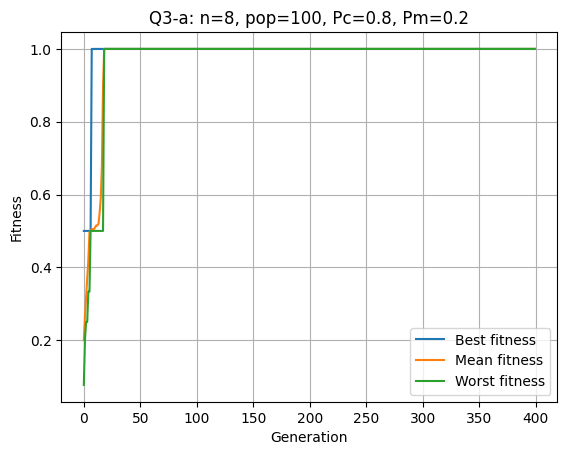

Best permutation: [0 4 7 5 2 6 1 3]
Best fitness: 1.0 conflicts: 0


In [40]:
cfg = BASE_CONFIGS[0]
res_a = run_ea_nqueens(
    n=cfg["n"],
    pop_size=cfg["pop_size"],
    max_generations=cfg["max_generations"],
    Pc=cfg["Pc"],
    Pm=cfg["Pm"],
    selection_type="roulette",
    random_seed=0
)

plot_evolution(
    res_a["best_history"],
    res_a["worst_history"],
    res_a["mean_history"],
    title="Q3-a: n=8, pop=100, Pc=0.8, Pm=0.2"
)

best_info_a = get_best_solution_info_nq(res_a)
print("Best permutation:", best_info_a["perm"])
print("Best fitness:", best_info_a["fitness"], "conflicts:", best_info_a["conflicts"])


### 2-
تعداد ۶ اجرای مختلف و نمودار میانگین و انحراف معیار

In [18]:
RUNS = 6   # طبق صورت سوال

# الف و ب: n=8، pop=100، gens=400، Pc=0.8، Pm=0.2
BASE_CONFIGS = [
    {
        "question": "a_b_base_n8",
        "n": 8,
        "pop_size": 100,
        "max_generations": 400,
        "Pc": 0.8,
        "Pm": 0.2,
    }
]

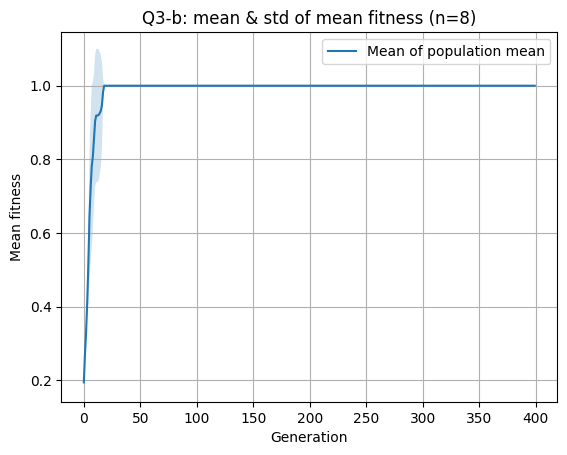

In [41]:
mean_b, std_b = multi_run_mean_std_nq(
    n=8,
    pop_size=100,
    max_generations=400,
    Pc=0.8,
    Pm=0.2,
    runs=RUNS,
    selection_type="roulette"
)

plot_mean_std(mean_b, std_b, title="Q3-b: mean & std of mean fitness (n=8)")


In [ ]:
RUNS = 12   # طبق صورت سوال

# الف و ب: n=8، pop=100، gens=400، Pc=0.8، Pm=0.2
BASE_CONFIGS = [
    {
        "question": "a_b_base_n8",
        "n": 8,
        "pop_size": 100,
        "max_generations": 400,
        "Pc": 0.8,
        "Pm": 0.2,
    }
]

### 3-
اثر اندازه‌ی مسئله (n ∈ {8,9,10,11})

معیار عملکرد = میانگین برازندگی جمعیت نهایی در هر اجرا

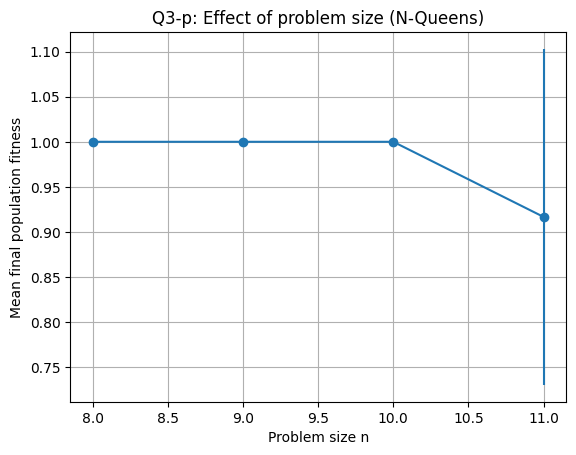

In [42]:
problem_sizes = [8, 9, 10, 11]
mean_perf = []
std_perf  = []

for n in problem_sizes:
    run_means = []
    for r in range(RUNS):
        res = run_ea_nqueens(
            n=n,
            pop_size=100,
            max_generations=400,
            Pc=0.8,
            Pm=0.2,
            selection_type="roulette",
            random_seed=r
        )
        final_mean = float(np.mean(res["final_fitnesses"]))
        run_means.append(final_mean)
    mean_perf.append(np.mean(run_means))
    std_perf.append(np.std(run_means))

plt.figure()
plt.errorbar(problem_sizes, mean_perf, yerr=std_perf, fmt='-o')
plt.xlabel("Problem size n")
plt.ylabel("Mean final population fitness")
plt.title("Q3-p: Effect of problem size (N-Queens)")
plt.grid(True)
plt.show()


### 4-
اثر تعداد نسل‌ها {50,100,200,300} برای هر n


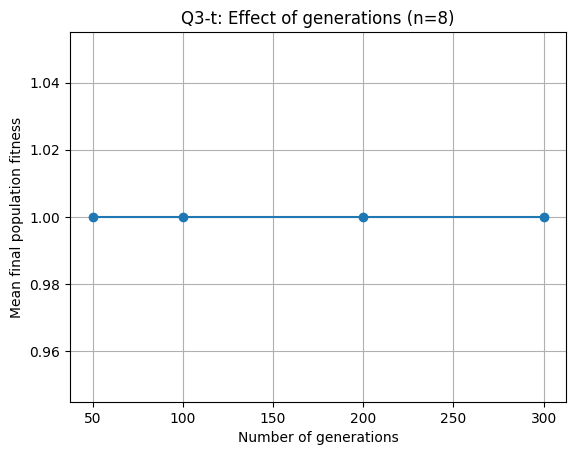

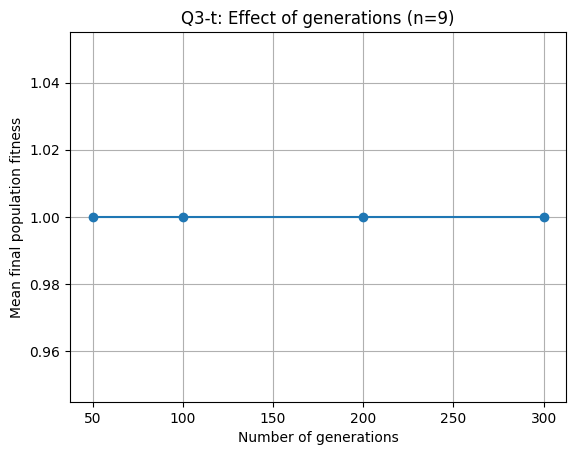

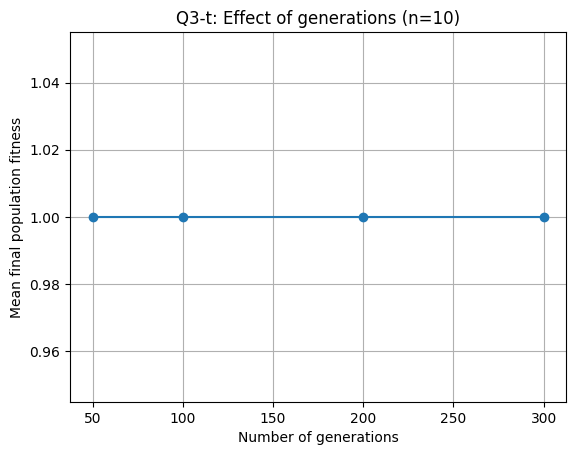

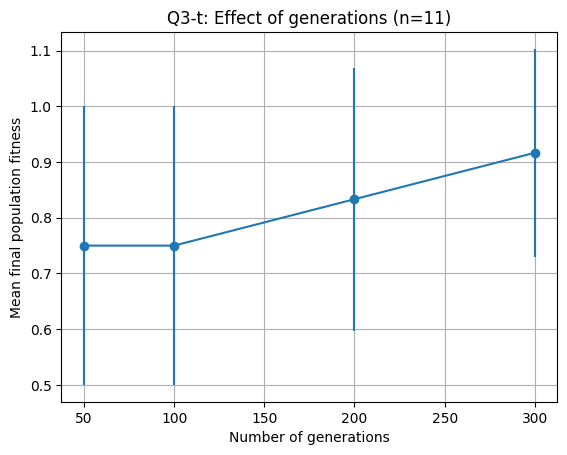

In [43]:
gen_values = [50, 100, 200, 300]

for n in problem_sizes:
    mean_perf = []
    std_perf  = []
    for gens in gen_values:
        run_means = []
        for r in range(RUNS):
            res = run_ea_nqueens(
                n=n,
                pop_size=100,
                max_generations=gens,
                Pc=0.8,
                Pm=0.2,
                selection_type="roulette",
                random_seed=r
            )
            final_mean = float(np.mean(res["final_fitnesses"]))
            run_means.append(final_mean)
        mean_perf.append(np.mean(run_means))
        std_perf.append(np.std(run_means))

    plt.figure()
    plt.errorbar(gen_values, mean_perf, yerr=std_perf, fmt='-o')
    plt.xlabel("Number of generations")
    plt.ylabel("Mean final population fitness")
    plt.title(f"Q3-t: Effect of generations (n={n})")
    plt.grid(True)
    plt.show()


### 5-
تأثیر اندازه جمعیت (popSize ∈ {50, 100, 200, 300})

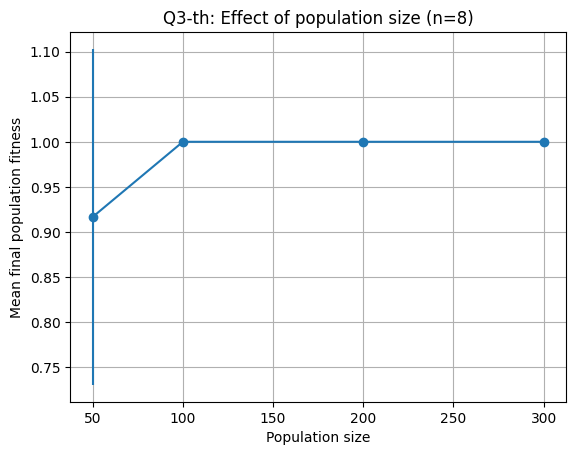

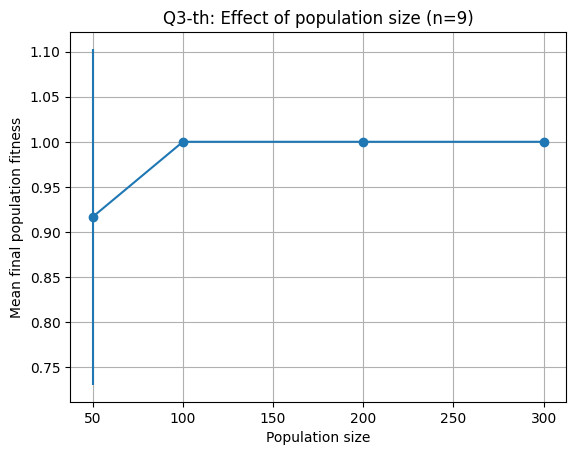

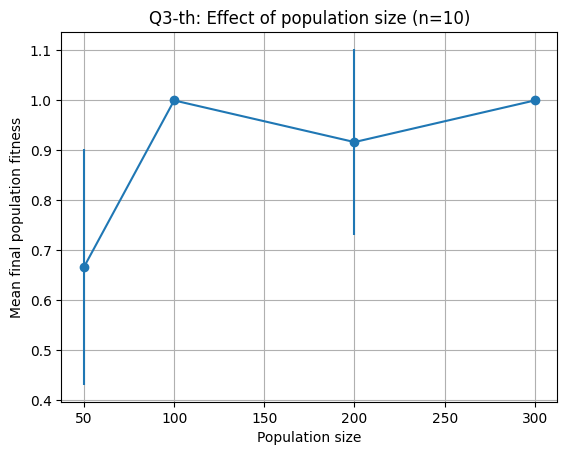

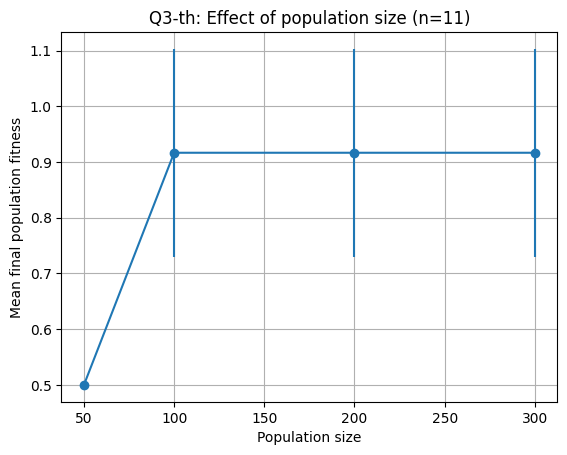

In [44]:
pop_sizes = [50, 100, 200, 300]

for n in problem_sizes:
    mean_perf = []
    std_perf  = []
    for pop_size in pop_sizes:
        run_means = []
        for r in range(RUNS):
            res = run_ea_nqueens(
                n=n,
                pop_size=pop_size,
                max_generations=400,
                Pc=0.8,
                Pm=0.2,
                selection_type="roulette",
                random_seed=r
            )
            final_mean = float(np.mean(res["final_fitnesses"]))
            run_means.append(final_mean)
        mean_perf.append(np.mean(run_means))
        std_perf.append(np.std(run_means))

    plt.figure()
    plt.errorbar(pop_sizes, mean_perf, yerr=std_perf, fmt='-o')
    plt.xlabel("Population size")
    plt.ylabel("Mean final population fitness")
    plt.title(f"Q3-th: Effect of population size (n={n})")
    plt.grid(True)
    plt.show()


### 6-
تأثیر احتمال بازترکیب

Pc ∈ {0.6,0.7,0.9,1}


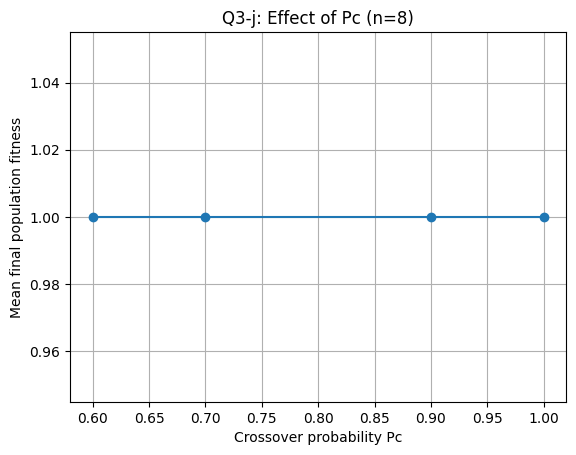

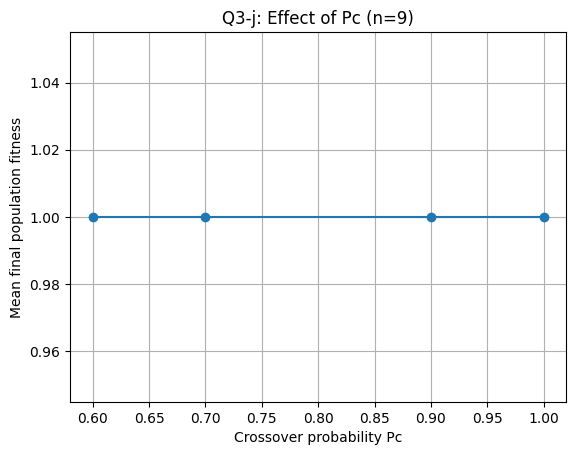

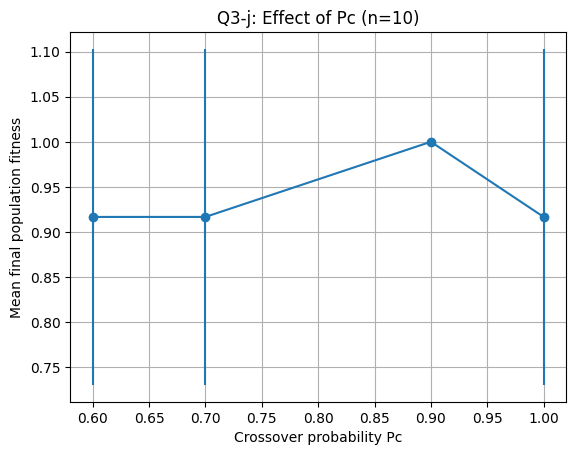

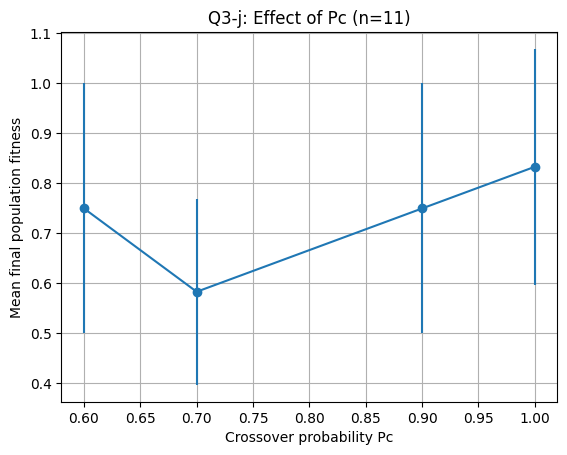

In [45]:
Pc_values = [0.6, 0.7, 0.9, 1.0]

for n in problem_sizes:
    mean_perf = []
    std_perf  = []
    for Pc in Pc_values:
        run_means = []
        for r in range(RUNS):
            res = run_ea_nqueens(
                n=n,
                pop_size=100,
                max_generations=400,
                Pc=Pc,
                Pm=0.2,
                selection_type="roulette",
                random_seed=r
            )
            final_mean = float(np.mean(res["final_fitnesses"]))
            run_means.append(final_mean)
        mean_perf.append(np.mean(run_means))
        std_perf.append(np.std(run_means))

    plt.figure()
    plt.errorbar(Pc_values, mean_perf, yerr=std_perf, fmt='-o')
    plt.xlabel("Crossover probability Pc")
    plt.ylabel("Mean final population fitness")
    plt.title(f"Q3-j: Effect of Pc (n={n})")
    plt.grid(True)
    plt.show()


### 7-
تأثیر احتمال جهش

Pm ∈ {0.05,0.1,0.3,0.5}

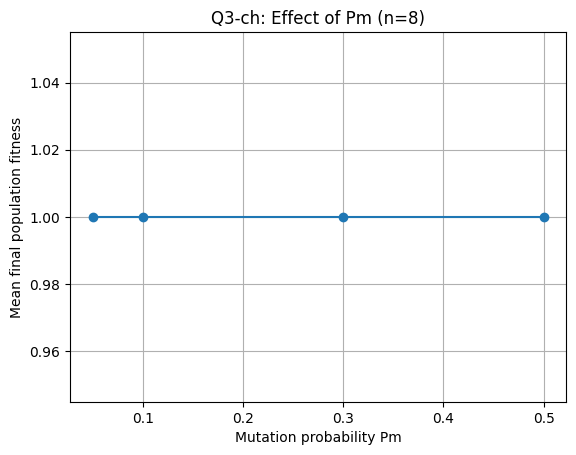

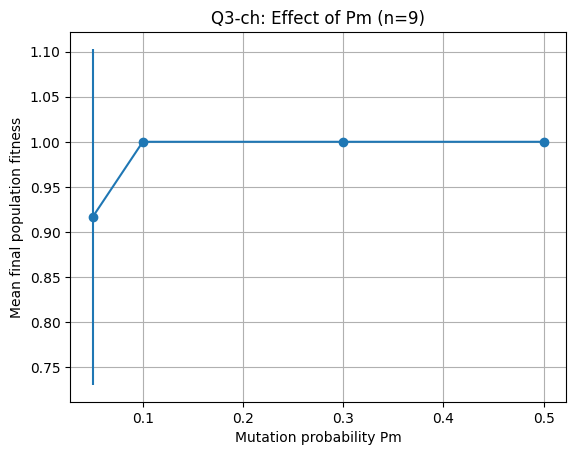

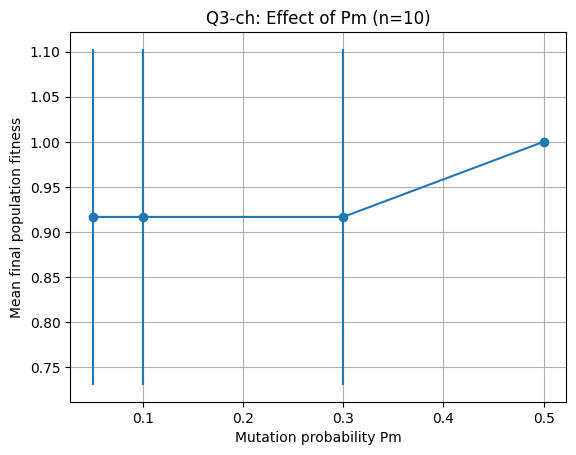

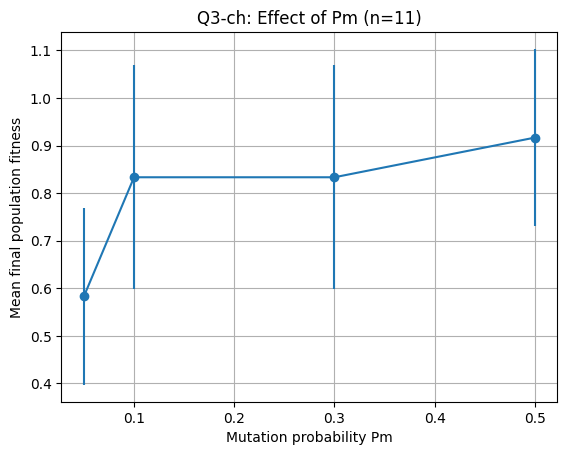

In [46]:
Pm_values = [0.05, 0.1, 0.3, 0.5]

for n in problem_sizes:
    mean_perf = []
    std_perf  = []
    for Pm in Pm_values:
        run_means = []
        for r in range(RUNS):
            res = run_ea_nqueens(
                n=n,
                pop_size=100,
                max_generations=400,
                Pc=0.8,
                Pm=Pm,
                selection_type="roulette",
                random_seed=r
            )
            final_mean = float(np.mean(res["final_fitnesses"]))
            run_means.append(final_mean)
        mean_perf.append(np.mean(run_means))
        std_perf.append(np.std(run_means))

    plt.figure()
    plt.errorbar(Pm_values, mean_perf, yerr=std_perf, fmt='-o')
    plt.xlabel("Mutation probability Pm")
    plt.ylabel("Mean final population fitness")
    plt.title(f"Q3-ch: Effect of Pm (n={n})")
    plt.grid(True)
    plt.show()


### 8-
بهترین راه‌حل برای تمام تنظیم‌ها

In [48]:
best_rows = []

for cfg in ALL_CONFIGS_NQUEENS:
    n          = cfg["n"]
    pop_size   = cfg["pop_size"]
    max_gen    = cfg["max_generations"]
    Pc         = cfg["Pc"]
    Pm         = cfg["Pm"]
    question   = cfg["question"]

    best_overall = None

    for r in range(RUNS):
        res = run_ea_nqueens(
            n=n,
            pop_size=pop_size,
            max_generations=max_gen,
            Pc=Pc, Pm=Pm,
            selection_type="roulette",
            random_seed=r
        )
        info = get_best_solution_info_nq(res)
        if (best_overall is None) or (info["fitness"] > best_overall["fitness"]):
            best_overall = info
            best_overall["run"] = r

    best_rows.append({
        "question": question,
        "n": n,
        "pop_size": pop_size,
        "max_generations": max_gen,
        "Pc": Pc,
        "Pm": Pm,
        "best_run": best_overall["run"],
        "best_fitness": best_overall["fitness"],
        "conflicts": best_overall["conflicts"],
        "perm": " ".join(str(x) for x in best_overall["perm"]),
    })

best_df_nqueens = pd.DataFrame(best_rows)
best_df_nqueens.head()
best_df_nqueens.to_csv("EA_nqueens_best_solutions_all_configs.csv", index=False)


### 9-
تورنومنت

Best config: {'question': 'a_b_base_n8', 'n': 8, 'pop_size': 100, 'max_generations': 400, 'Pc': 0.8, 'Pm': 0.2, 'best_run': 0, 'best_fitness': 1.0, 'conflicts': 0, 'perm': '0 4 7 5 2 6 1 3'}


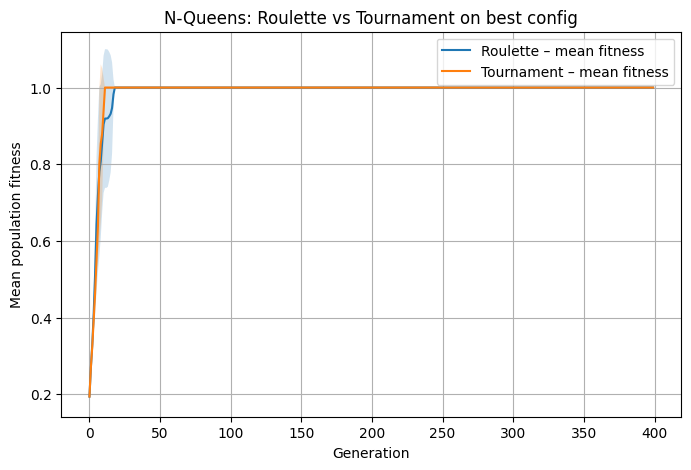

In [49]:
# بهترین ردیف از جدول
idx_best = best_df_nqueens["best_fitness"].idxmax()
row_best = best_df_nqueens.loc[idx_best]

best_n   = int(row_best["n"])
best_pop = int(row_best["pop_size"])
best_gen = int(row_best["max_generations"])
best_Pc  = float(row_best["Pc"])
best_Pm  = float(row_best["Pm"])

print("Best config:", row_best.to_dict())

num_runs_compare = 6

all_mean_r = []
all_mean_t = []

for r in range(num_runs_compare):
    res_r = run_ea_nqueens(
        n=best_n, pop_size=best_pop, max_generations=best_gen,
        Pc=best_Pc, Pm=best_Pm,
        selection_type="roulette",
        random_seed=r
    )
    all_mean_r.append(res_r["mean_history"])

    res_t = run_ea_nqueens(
        n=best_n, pop_size=best_pop, max_generations=best_gen,
        Pc=best_Pc, Pm=best_Pm,
        selection_type="tournament",
        tournament_size=2,
        random_seed=r
    )
    all_mean_t.append(res_t["mean_history"])

all_mean_r = np.array(all_mean_r)
all_mean_t = np.array(all_mean_t)

mean_r = np.mean(all_mean_r, axis=0)
std_r  = np.std(all_mean_r, axis=0)
mean_t = np.mean(all_mean_t, axis=0)
std_t  = np.std(all_mean_t, axis=0)

gens = np.arange(best_gen)

plt.figure(figsize=(8,5))
plt.plot(gens, mean_r, label="Roulette – mean fitness")
plt.fill_between(gens, mean_r-std_r, mean_r+std_r, alpha=0.2)

plt.plot(gens, mean_t, label="Tournament – mean fitness")
plt.fill_between(gens, mean_t-std_t, mean_t+std_t, alpha=0.2)

plt.xlabel("Generation")
plt.ylabel("Mean population fitness")
plt.title("N-Queens: Roulette vs Tournament on best config")
plt.legend()
plt.grid(True)
plt.show()
